## Rstanの動作確認

コード
https://github.com/logics-of-blue/book-r-stan-bayesian-model-intro/blob/master/book-data/5-2-%E3%83%AD%E3%83%BC%E3%82%AB%E3%83%AB%E3%83%AC%E3%83%99%E3%83%AB%E3%83%A2%E3%83%87%E3%83%AB.R


In [2]:
library(tidyverse)

In [3]:
library(rstan)
library(bayesplot)
library(ggfortify)
library(gridExtra)

Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [4]:
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

[1] 1 4 6

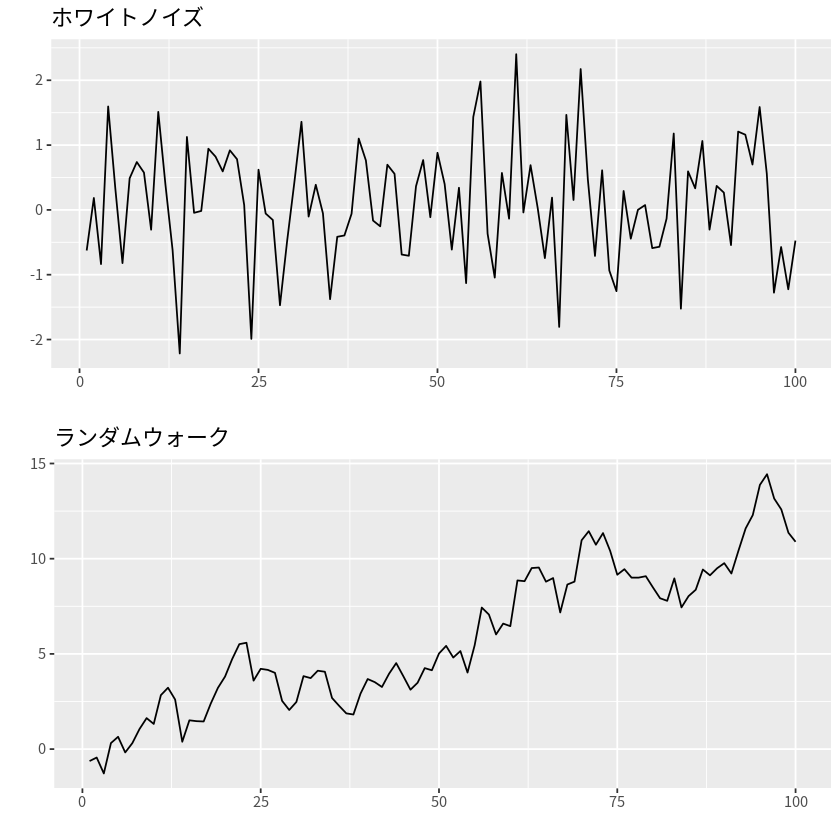

In [5]:
# 正規ホワイトノイズ
set.seed(1)
wn <- rnorm(n = 100, mean = 0, sd = 1)

# 累積和をとる関数cumsumの説明
cumsum(c(1,3,2))

# ランダムウォーク
rw <- cumsum(wn)

# グラフを作る
p_wn_1 <- autoplot(ts(wn), main = "ホワイトノイズ")
p_rw_1 <- autoplot(ts(rw), main = "ランダムウォーク")

# 2つのグラフをまとめる
grid.arrange(p_wn_1, p_rw_1)

In [6]:
# 複数のホワイトノイズ・ランダムウォーク系列
wn_mat <- matrix(nrow = 100, ncol = 20)
rw_mat <- matrix(nrow = 100, ncol = 20)

set.seed(1)
for(i in 1:20){
  wn <- rnorm(n = 100, mean = 0, sd = 1)
  wn_mat[,i] <- wn
  rw_mat[,i] <- cumsum(wn)
}


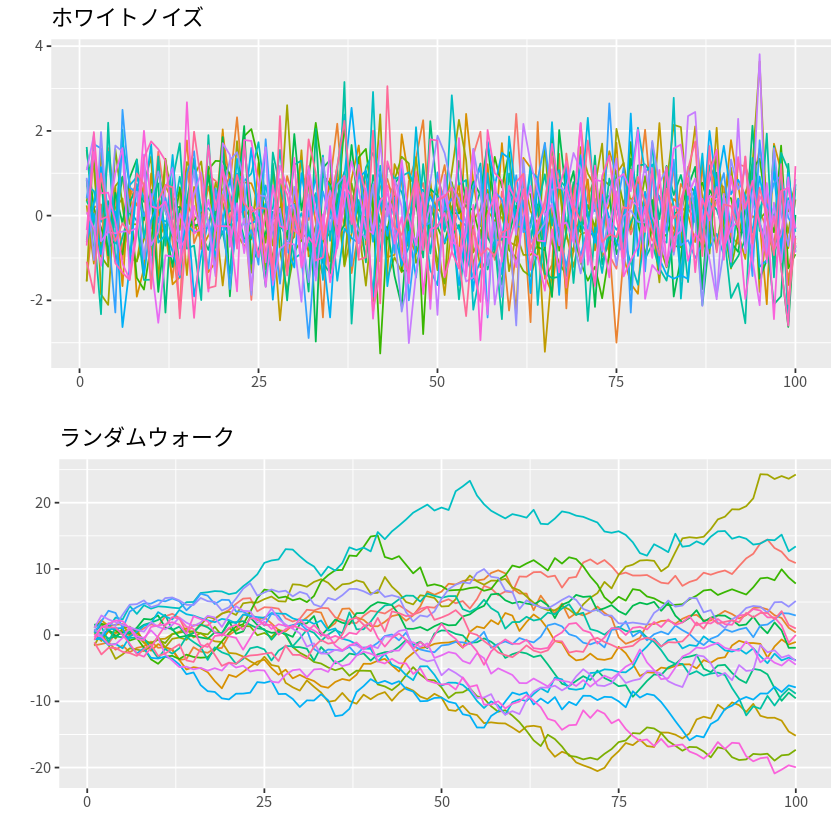

In [7]:
# グラフを作る
p_wn_2 <- autoplot(ts(wn_mat), facets = F, main = "ホワイトノイズ") + 
  theme(legend.position = 'none') # 凡例を消す

p_rw_2 <- autoplot(ts(rw_mat), facets = F, main = "ランダムウォーク") + 
  theme(legend.position = 'none') # 凡例を消す

# 2つのグラフをまとめる
grid.arrange(p_wn_2, p_rw_2)

In [8]:
sales_df <- read.csv(url("https://raw.githubusercontent.com/logics-of-blue/book-r-stan-bayesian-model-intro/master/book-data/5-2-1-sales-ts-1.csv"))

In [9]:
head(sales_df)

date       sales
1 2010-01-01 23.9 
2 2010-01-02 19.0 
3 2010-01-03 20.3 
4 2010-01-04 24.2 
5 2010-01-05 19.3 
6 2010-01-06 16.7

In [10]:
sales_df$date <- as.POSIXct(sales_df$date)

# データの先頭行を表示
head(sales_df, n = 3)

# POSIXctの補足
POSIXct_time <- as.POSIXct("1970-01-01 00:00:05", tz="UTC")
as.numeric(POSIXct_time)

date       sales
1 2010-01-01 23.9 
2 2010-01-02 19.0 
3 2010-01-03 20.3

[1] 5

In [ ]:
# ローカルレベルモデルの推定 -------------------------------------------------------------

# データの準備
data_list <- list(
  y = sales_df$sales, 
  T = nrow(sales_df)
)

# モデルの推定
local_level_stan <- stan(
  file = "local-level.stan",
  data = data_list,
  seed = 1
)

Warning message in readLines(file, warn = TRUE):
“ '/home/jupyter/Analytics/docker-stack-for-bi/bayes/local-level.stan' で不完全な最終行が見つかりました ”
recompiling to avoid crashing R session



In [ ]:
# 収束の確認
mcmc_rhat(rhat(local_level_stan))


# 結果の表示
print(local_level_stan,
      pars = c("s_w", "s_v","lp__"),
      probs = c(0.025, 0.5, 0.975))


In [ ]:
# 図示をする関数 -----------------------------------------------------------------

plotSSM <- function(mcmc_sample, time_vec, obs_vec = NULL,
                    state_name, graph_title, y_label,
                    date_labels = "%Y年%m月"){
  # 状態空間モデルを図示する関数
  #
  # Args:
  #   mcmc_sample : MCMCサンプル
  #   time_vec    : 時間軸(POSIXct)のベクトル
  #   obs_vec     : (必要なら)観測値のベクトル
  #   state_name  : 図示する状態の変数名
  #   graph_title : グラフタイトル
  #   y_label     : y軸のラベル
  #   date_labels : 日付の書式
  #
  # Returns:
  #   ggplot2により生成されたグラフ
  
  # すべての時点の状態の、95%区間と中央値
  result_df <- data.frame(t(apply(
    X = mcmc_sample[[state_name]],
    MARGIN = 2, quantile, probs = c(0.025, 0.5, 0.975)
  )))
  
  # 列名の変更
  colnames(result_df) <- c("lwr", "fit", "upr")
  
  # 時間軸の追加
  result_df$time <- time_vec
  
  # 観測値の追加
  if(!is.null(obs_vec)){
    result_df$obs <- obs_vec
  }
  
  # 図示
  p <- ggplot(data = result_df, aes(x = time)) + 
    labs(title = graph_title) +
    ylab(y_label) +
    geom_line(aes(y = fit), size = 1.2) +
    geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3) + 
    scale_x_datetime(date_labels = date_labels)
  
  # 観測値をグラフに追加
  if(!is.null(obs_vec)){
    p <- p + geom_point(alpha = 0.6, size = 0.9, 
                        data = result_df, aes(x = time, y = obs))
  }
  
  # グラフを返す
  return(p)
}


In [ ]:
# 結果の図示 -------------------------------------------------------------------

# 生成された乱数を格納
mcmc_sample <- rstan::extract(local_level_stan)

# Stanにおける状態を表す変数名
state_name <- "mu"

# 1時点目の状態の95%ベイズ信用区間と中央値を得る
quantile(mcmc_sample[[state_name]][, 1], 
         probs=c(0.025, 0.5, 0.975))

# すべての時点の状態の、95%ベイズ信用区間と中央値
result_df <- data.frame(t(apply(
  X = mcmc_sample[[state_name]],# 実行対象となるデータ
  MARGIN = 2,                   # 列を対象としてループ
  FUN = quantile,               # 実行対象となる関数
  probs=c(0.025, 0.5, 0.975)    # 上記関数に入れる引数
)))

# 列名の変更
colnames(result_df) <- c("lwr", "fit", "upr")

# 時間軸の追加
result_df$time <- sales_df$date

# 観測値の追加
result_df$obs <- sales_df$sales

# 図示のためのデータの確認
head(result_df, n = 3)

# 図示
ggplot(data = result_df, aes(x = time, y = obs)) + 
  labs(title="ローカルレベルモデルの推定結果") +
  ylab("sales") + 
  geom_point(alpha = 0.6, size = 0.9) +
  geom_line(aes(y = fit), size = 1.2) +
  geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3) + 
  scale_x_datetime(date_labels = "%Y年%m月")
